## 0. Install and Import Dependencies

In [1]:
!pip install easyocr
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [70]:
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr
from PIL import Image

## 1. Read in Image, Grayscale and Blur

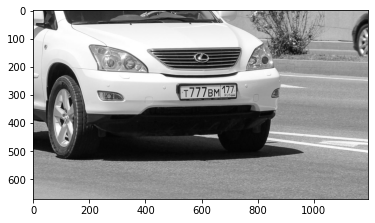

In [59]:
img = cv2.imread('/content/im1.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

## 2. Apply filter and find edges for localization

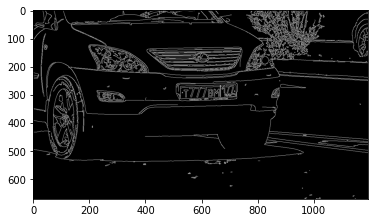

In [60]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

## 3. Find Contours and Apply Mask

In [61]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [62]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

In [63]:
location

array([[[723, 268]],

       [[527, 270]],

       [[525, 314]],

       [[722, 308]]], dtype=int32)

In [64]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

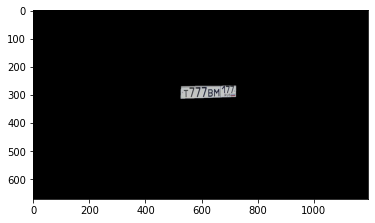

In [65]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [66]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

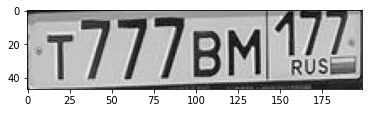

In [67]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

## 5. Render Result

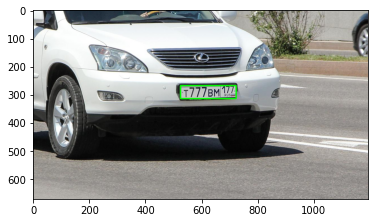

In [69]:
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

# 6. Metric

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
df_train = pd.read_json('/content/drive/MyDrive/license-plate-detection/train.json')

df_exploded = df_train.explode('nums')['nums'].apply(pd.Series)['text']
df_train['text'] = df_exploded[~df_exploded.index.duplicated(keep='first')]

df_location = df_train.explode('nums')['nums'].apply(pd.Series)['box']
df_train['location'] = df_location[~df_location.index.duplicated(keep='first')]

df_train.to_csv('/content/drive/MyDrive/license-plate-detection/real_numbers.csv')

In [5]:
def crop_number(im_path_in, im_path_out):
  img = cv2.imread(im_path_in)#'/content/im1.png')
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
  edged = cv2.Canny(bfilter, 30, 200) #Edge detection

  keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contours = imutils.grab_contours(keypoints)
  contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

  location = None
  for contour in contours:
      approx = cv2.approxPolyDP(contour, 10, True)
      if len(approx) == 4:
          location = approx
          break

  mask = np.zeros(gray.shape, np.uint8)
  new_image = cv2.drawContours(mask, [location], 0,255, -1)
  new_image = cv2.bitwise_and(img, img, mask=mask)

  (x,y) = np.where(mask==255)
  (x1, y1) = (np.min(x), np.min(y))
  (x2, y2) = (np.max(x), np.max(y))
  cropped_image = gray[x1:x2+1, y1:y2+1]

  im = Image.fromarray(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
  im.save(im_path_out)

  return location

In [52]:
from tqdm import tqdm

def normalize_location(loc):
  return [list(i[0]) for i in loc]


data_size = 6000
cols = ['location_cv2', 'file', 'locatoin_test', 'text_test', 'intersec_area']
df_out = pd.DataFrame(columns=cols, index=range(data_size))
i = 0
for file in tqdm(df_train['file'][:6000]):
  path = '/content/drive/MyDrive/license-plate-detection/' + file
  path_out = path.replace('train','out')

  try:
    location = crop_number(path, path_out)
    df_out.loc[i].location_cv2 = normalize_location(location)
    df_out.loc[i].file = file
    df_out.loc[i].locatoin_test = df_train['location'].loc[df_train['file']==file].iloc[0]
    df_out.loc[i].text_test = df_train['text'].loc[df_train['file']==file].iloc[0]

    polygon = Polygon(df_out.loc[i].locatoin_test)
    other_polygon = Polygon(df_out.loc[i].location_cv2)
    intersection = polygon.intersection(other_polygon)
    df_out.loc[i].intersec_area = intersection.area/polygon.area

    i += 1
  except:
    pass
  

100%|██████████| 6000/6000 [11:10<00:00,  8.95it/s]


In [79]:
df_out = df_out.loc[df_out['file'].notna()]
df_out.to_csv('/content/drive/MyDrive/license-plate-detection/df_out.csv')

In [80]:
df_out

,location_cv2,file,locatoin_test,text_test,intersec_area
0,"[[467, 936], [471, 1033], [598, 1050], [596, 9...",train/0.jpg,"[[180, 889], [596, 951], [598, 1056], [185, 983]]",B060BB125,0.303018
1,"[[383, 196], [363, 352], [420, 363], [401, 218]]",train/1.jpg,"[[794, 661], [1004, 618], [1009, 670], [799, 7...",M938OX116,0.0
2,"[[944, 760], [1012, 764], [1021, 748], [948, 7...",train/2.jpg,"[[286, 603], [346, 606], [346, 621], [285, 616]]",A549XA163,0.0
3,"[[609, 388], [574, 501], [690, 507], [729, 387]]",train/3.jpg,"[[217, 486], [489, 487], [488, 580], [204, 570]]",O934MO190,0.0
4,"[[153, 320], [157, 352], [262, 376], [258, 338]]",train/5.bmp,"[[153, 318], [262, 339], [264, 371], [155, 348]]",A750PY35,0.934893
...,...,...,...,...,...
5103,"[[265, 457], [267, 495], [481, 502], [478, 463]]",train/5994.jpg,"[[264, 448], [483, 460], [482, 513], [265, 499]]",T911XY47,0.723668
5104,"[[274, 114], [280, 154], [212, 150], [234, 119]]",train/5995.bmp,"[[318, 280], [501, 296], [501, 337], [325, 313]]",А555ОY35,0.0
5105,"[[299, 68], [291, 44], [232, 58], [262, 79]]",train/5996.jpg,"[[298, 594], [666, 586], [659, 685], [285, 690]]",A599AA190,0.0
5106,"[[1486, 636], [1170, 650], [1169, 713], [1489,...",train/5997.jpg,"[[1176, 651], [1474, 638], [1477, 699], [1176,...",O666PB36,0.978607


In [84]:
df_out.loc[df_out['intersec_area'] > 0.8].shape[0]/df_out.shape[0]

0.19596711041503523